In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib tk
we_keys = [0, 10, -1]
eff_keys = [0, 0.2, 0.6, 1]
db_keys = [0, 1, 10, 100]

# Create a dictionary dict with all the policies like dict[we][db][eff] = policy
large_policies = {
    we: {eff: {db: np.zeros((5,2)) for db in db_keys} for eff in eff_keys} for we in we_keys
}

large_policies[10][0][0] = np.array([[-493.255, 0. ], [-491.795, 0. ], [-484.36, 0. ], [-482.56, 0. ], [-490.73, 0. ]])
large_policies[10][0][1] = np.array([[-493.255,0.],[-491.795,0.],[-484.36,0.  ],[-482.56,0.  ],[-490.73,0.  ]])
large_policies[10][0][10] =  np.array([[-493.515,0.],[-494.93,0.  ],[-494.14,0.  ],[-494.685,0.],[-494.33,0.  ]])
large_policies[10][0][100] =  np.array([[-493.515,0.],[-494.93,0.  ],[-494.14,0.  ],[-494.685,0.],[-494.33,0.  ]])
large_policies[10][0.2][0] =  np.array([[-159.21,0.  ],[-495.405,0.],[-487.79,0.  ],[-487.555,0.],[-495.415,0.]])
large_policies[10][0.2][1] =  np.array([[-135.99  , 31.2263], [-379.166,  0. ], [-473.507,  0. ], [-371.311,  0. ], [-431.127,  0. ]])
large_policies[10][0.2][10] =  np.array([])
large_policies[10][0.2][100] =  np.array([[-148.09,40.852],[-410.19,0.  ],[-419.235,0.],[-387.675,0.],[-417.115,0.]])
large_policies[10][0.6][0] =  np.array([[-205.586,  0. ], [-285.879,  0. ], [-278.435,  0. ], [-495.237,  0. ], [-495.861,  0. ]])
large_policies[10][0.6][1] =  np.array([[-151.564 ,    5.3354],[-105.249 ,    9.2631], [-146.008 ,    6.4743], [-2.51422e+02,  1.33000e-02], [-2.40726e+02,  3.43000e-02]])
large_policies[10][0.6][10] =  np.array([[-301.76, 6.062], [-290.42, 6.566], [-300.8, 5.754], [-378.34, 0.826], [-383.4, 0.504]])
large_policies[10][0.6][100] =  np.array([[-313.905,7.3675], [-336.63, 5.8555], [-287.545, 10.9095], [-380.295, 1.7255], [-386.96, 1.5785]])
large_policies[10][1][0] =  np.array([])
large_policies[10][1][1] =  np.array([])
large_policies[10][1][10] =  np.array([])
large_policies[10][1][100] =  np.array([])

# Any policy with we = 0 is the same as the policy with we = 10 and db = 0
for eff in eff_keys:
    for db in db_keys:
        large_policies[0][eff][db] = large_policies[10][eff][0]



In [39]:
large_policies[10][0.2][1][:1].mean(axis=0)

array([-135.99  ,   31.2263])

In [27]:
large_policies[0][0.6][10]

array([[-205.586,    0.   ],
       [-285.879,    0.   ],
       [-278.435,    0.   ],
       [-495.237,    0.   ],
       [-495.861,    0.   ]])

In [23]:
# Function to get the intersection of two lines represented as f(we) = v0 + we*ve for a two given fixed sets of (v0, ve)
def get_intersection(v01, ve1, v02, ve2):
    if ve1 == ve2:
        return 0
    we = (v01 - v02) / (ve2 - ve1)
    return we
# get_intersection(mo_value_w10[2][0], mo_value_w10[2][1], mo_value_w0[2][0], mo_value_w0[2][1])

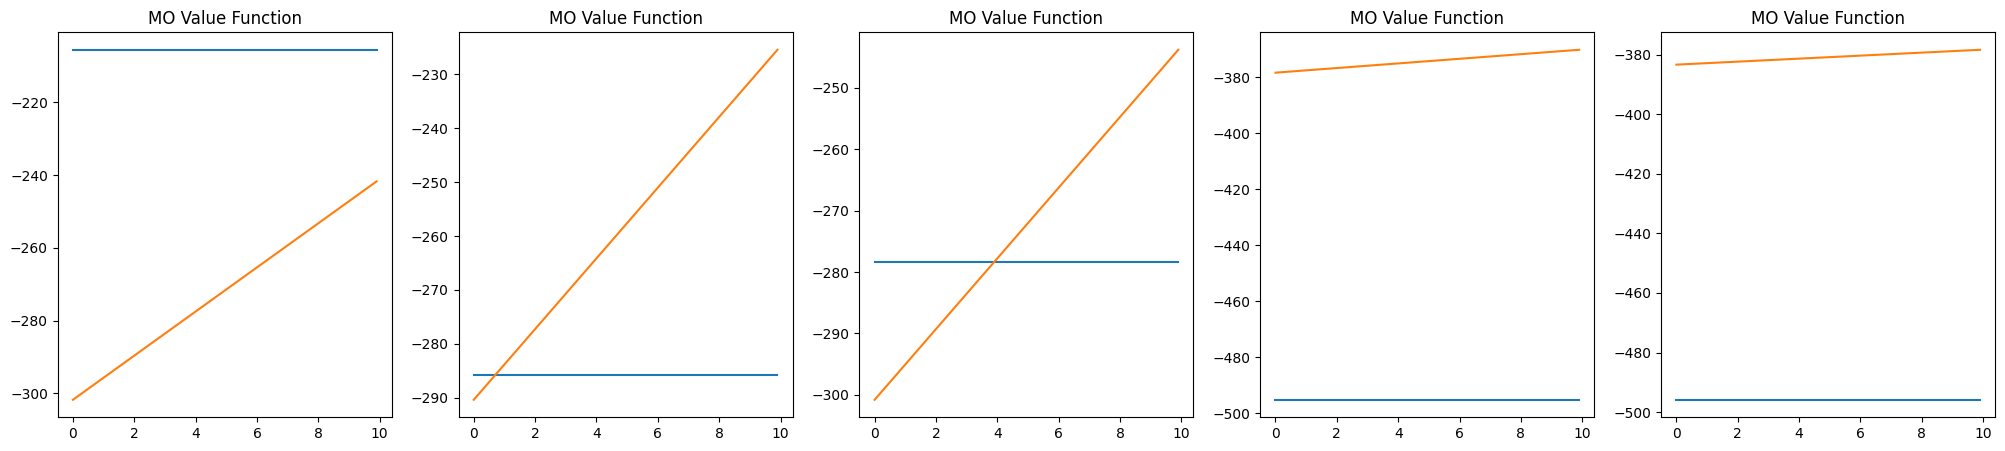

In [24]:
# Plot values as function of weight w that scales the reward
policies = large_policies

fig, axs = plt.subplots(1, 5, figsize=(25, 5)) 
step = 0.1
# for ag in mo_value_w10:
max_weight = 10
# Subplot for each agent
x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

setting = {"eff": 0.6, "db": 10}
weights = [0, 10]
for ag in range(5):
    axs[ag].set_title("MO Value Function")
    for we in weights:
        p = policies[we][setting["eff"]][setting["db"]]
        y = np.dot(p[ag], w)
        axs[ag].plot(x, y)

plt.show()

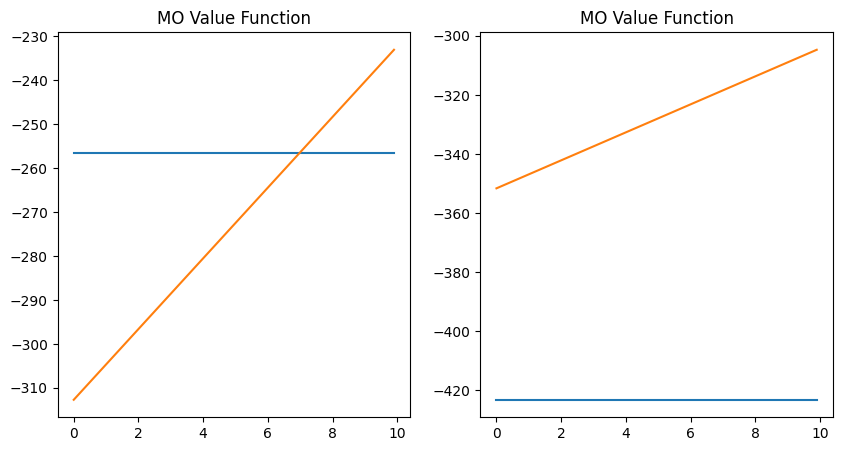

20.044324058113748
20.044324058113748


In [58]:
# Plot values as function of weight w that scales the reward
policies = large_policies

fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
step = 0.1
# for ag in mo_value_w10:
max_weight = 10
# Subplot for each agent
x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

setting = {"eff": 0.6, "db": 100}
weights = [0, 10]
n_eff = int(5 * setting["eff"])

for we in weights:
    axs[0].set_title("MO Value Function")
    p = policies[we][setting["eff"]][setting["db"]][:n_eff].mean(axis=0)
    y = np.dot(p, w)
    axs[0].plot(x, y)

    axs[1].set_title("MO Value Function")
    p = policies[we][setting["eff"]][setting["db"]][(n_eff-1):].mean(axis=0)
    y = np.dot(p, w)
    axs[1].plot(x, y)

plt.show()

# Print intersecctions
for group in range(2):
    p1 = policies[0][setting["eff"]][setting["db"]][:n_eff].mean(axis=0)
    p2 = policies[10][setting["eff"]][setting["db"]][(n_eff-1):].mean(axis=0)
    print(get_intersection(p1[0], p1[1], p2[0], p2[1]))

AttributeError: 'dict' object has no attribute 'shape'